In [1]:
from scipy.optimize import curve_fit
import pandas as pd
import random
import sys
from IPython.display import clear_output
from matplotlib import pyplot as plt

sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import toxic_asset_attack, random_swaps
from model.amm.global_state import GlobalState, historical_prices

In [2]:
# same seed, same parameters = same simulation result
random.seed(42)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.20},
    'AUSD': {'usd price': 1, 'weight': 0.10},
    'ETH': {'usd price': 2500, 'weight': 0.40},
    'DOT': {'usd price': 0.1, 'weight': 0.20}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'Omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            lrna_fee=0,
            asset_fee=0,
            preferred_stablecoin = 'USD',
            short_oracle_period = 12,
            long_oracle_period = 1200
        )
    },
    agents={
        'Attacker': Agent(
            holdings={'AUSD': float('inf')},
            trade_strategy=toxic_asset_attack(
                pool_id='Omnipool',
                asset_name='AUSD',
                trade_size=10000,
                start_timestep=800
            )
        ),
        'Trader': Agent(
            holdings={'HDX': 1000000, 'USD': 1000000, 'R1': 1000000, 'R2': 100000},
            trade_strategy=random_swaps(
                pool_id='Omnipool', 
                amount={
                    'ETH': 100 / assets['ETH']['usd price'], 
                    'HDX': 100 / assets['HDX']['usd price'], 
                    'AUSD': 100 / assets['AUSD']['usd price'], 
                    'DOT': 100 / assets['DOT']['usd price'], 
                    'USD': 100 / assets['USD']['usd price'], 
                  }
            )
        )
        
        # 'Arbitrageur': Agent(
        #     holdings={tkn: 100000000000 for tkn in list(assets.keys()) + ['LRNA']}, 
        #     trade_strategy=omnipool_feeless_arbitrage('Omnipool')
        # )
    },
    # evolve_function=historical_prices(price_list),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets}
)
initial_state.pools['Omnipool'].weight_cap['AUSD'] = 0.1
# initial_state.external_market['AUSD'] = 0
# print(initial_state)
time_steps = 1000
events = run.run(initial_state, time_steps=time_steps)


Starting simulation...
Execution time: 4.911 seconds.


<AxesSubplot:title={'center':'pool: Omnipool  liquidity USD '}>

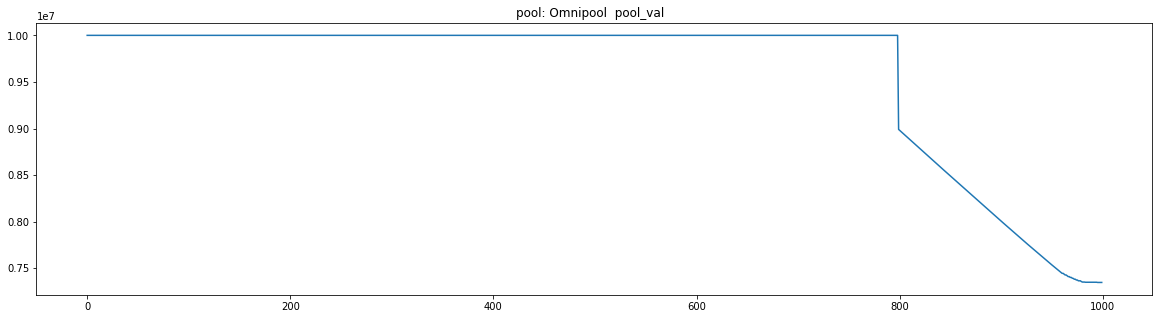

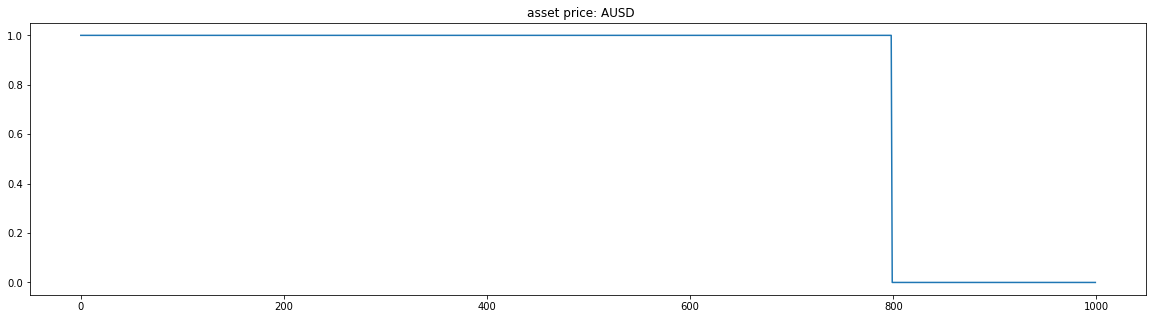

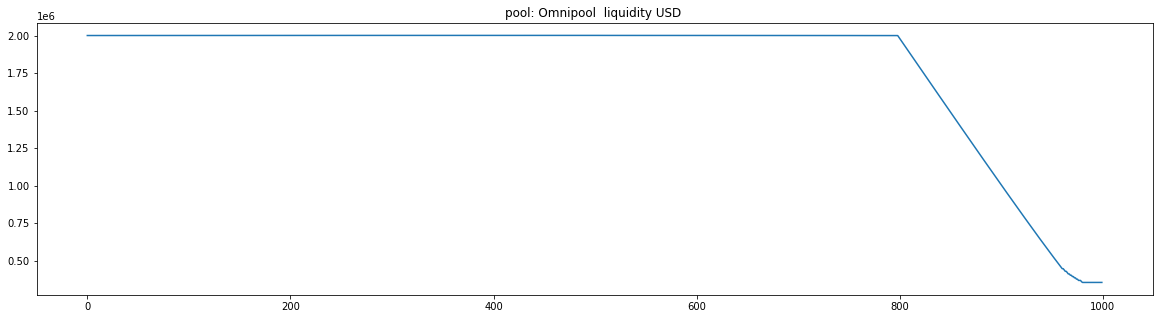

In [3]:
%matplotlib inline
events = processing.postprocessing(events, optional_params=['pool_val'])
pu.plot(events, pool='Omnipool', prop='pool_val')
ax = pu.plot(events, asset='AUSD')
pu.plot(events, pool='Omnipool', prop='price', key='FT', subplot=ax)
# pu.plot(events, pool='Omnipool', prop='price', key=['ETH', 'HDX', 'AUSD'])
pu.plot(events, pool='Omnipool', prop='liquidity', key='USD')

In [4]:
mitigated_state = initial_state.copy()
def press_brakes(self: OmnipoolState, tkn: str):
    f = 5
    return min(
        max(0.1, min((self.long_oracle[tkn].get('volume_in') or 1) / (
            self.short_oracle[tkn].get('volume_in')
            * self.short_oracle['AUSD'].get('liquidity')
            / self.long_oracle['AUSD'].get('liquidity')            
            or 1) * f, 1)),
        self.online_liquidity(tkn) / self.liquidity[tkn] + .01
        # 100
    )
mitigated_state.pools['Omnipool'].liquidity_coefficient_function = press_brakes
events2 = run.run(mitigated_state, time_steps)

Starting simulation...
Execution time: 8.96 seconds.


<AxesSubplot:title={'center':'pool: Omnipool short_oracle volume_in AUSD '}>

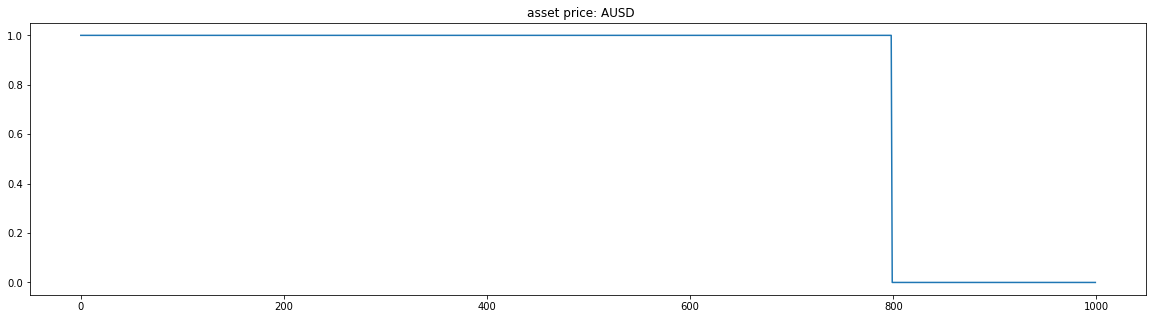

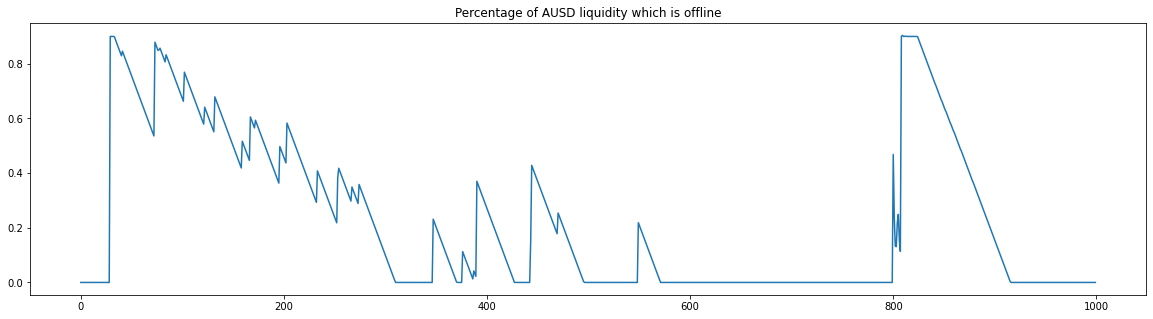

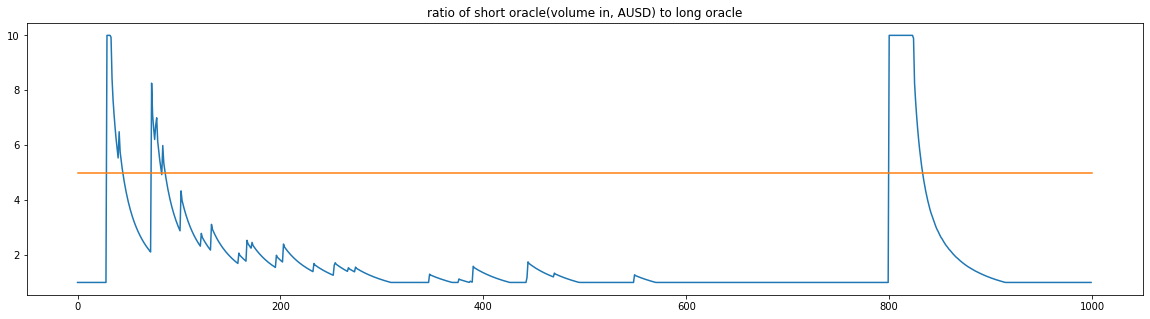

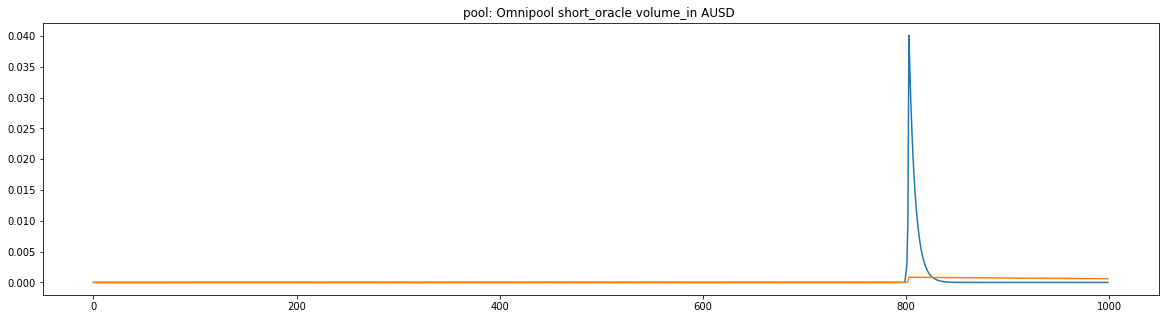

In [5]:
# pu.plot(events2, pool='Omnipool', prop='total_value_locked')
pu.plot
ax = pu.plot(events, asset='AUSD')
# pu.plot(events2, pool='Omnipool', prop='price', key='AUSD')

liquidity_offline_percent = [
    p / events2[i]['state'].pools['Omnipool'].liquidity['AUSD'] 
    for i, p in enumerate(pu.get_datastream(events2, pool='Omnipool', prop='liquidity_offline', key='AUSD'))
]
plt.figure(figsize=(20, 5))
plt.plot(range(len(events)), liquidity_offline_percent)
plt.title('Percentage of AUSD liquidity which is offline')

trigger = [
    1/ press_brakes(event['state'].pools['Omnipool'], 'AUSD')
    for event in events2
]
plt.figure(figsize=(20, 5))
plt.plot(range(len(events)), trigger)
plt.plot([0, len(events)], [5, 5])
plt.title('ratio of short oracle(volume in, AUSD) to long oracle')

ax = pu.plot(events2, pool='Omnipool', oracle='short_oracle', prop='volume_in', key='AUSD')
pu.plot(events2, pool='Omnipool', oracle='long_oracle', prop='volume_in', key='AUSD', subplot=ax)

<AxesSubplot:title={'center':'pool: Omnipool  lrna USD '}>

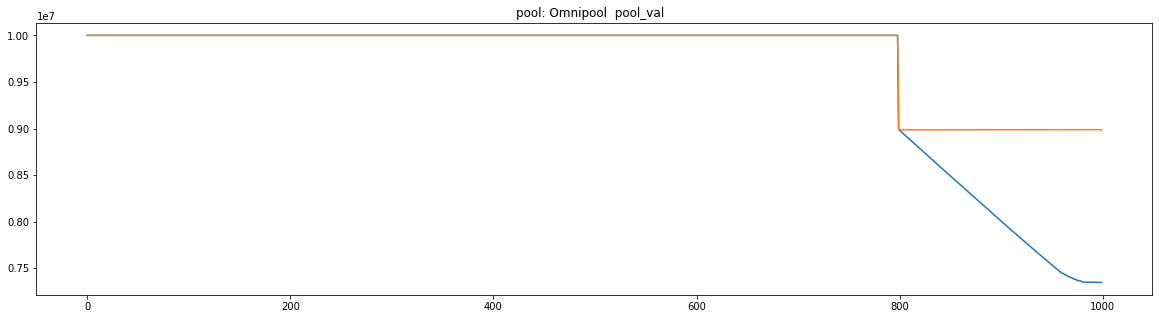

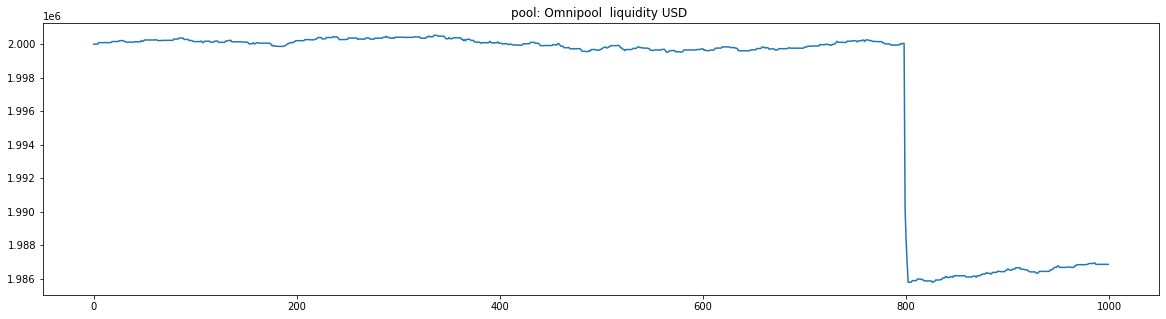

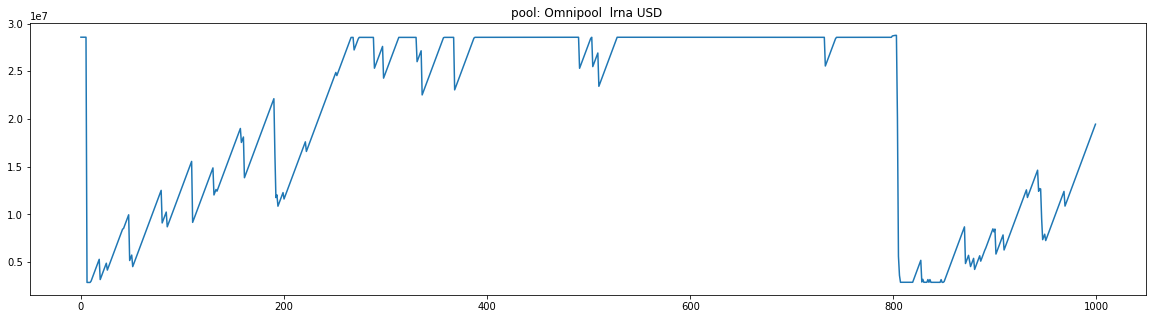

In [9]:
events = processing.postprocessing(events, optional_params= ['pool_val'])
events2 = processing.postprocessing(events2, optional_params= ['pool_val'])

ax = pu.plot(events, pool='Omnipool', prop='pool_val')
pu.plot(events2, pool='Omnipool', prop='pool_val', subplot=ax)
pu.plot(events2, pool='Omnipool', prop='liquidity', key='USD')
pu.plot(events2, pool='Omnipool', prop='lrna', key='USD')

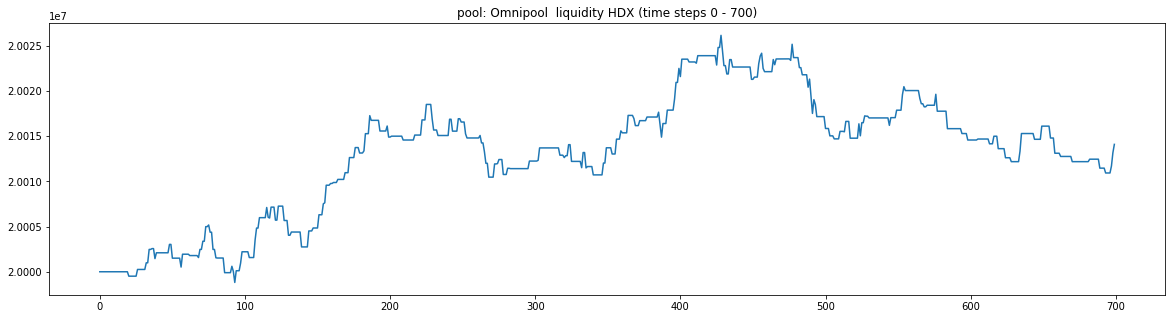

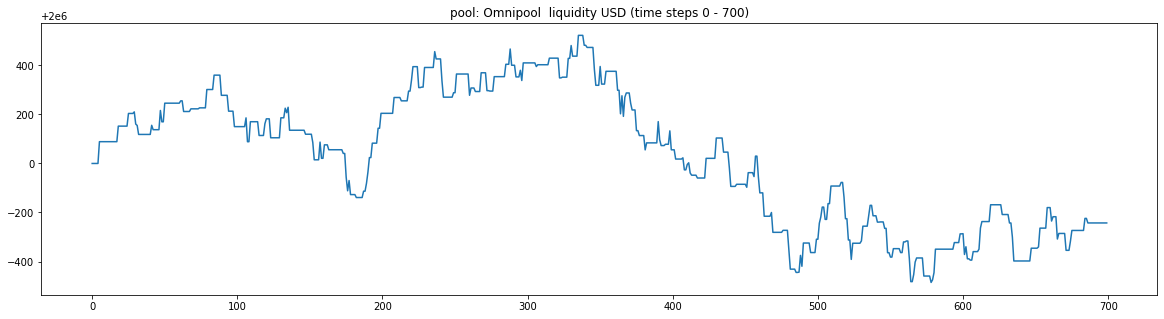

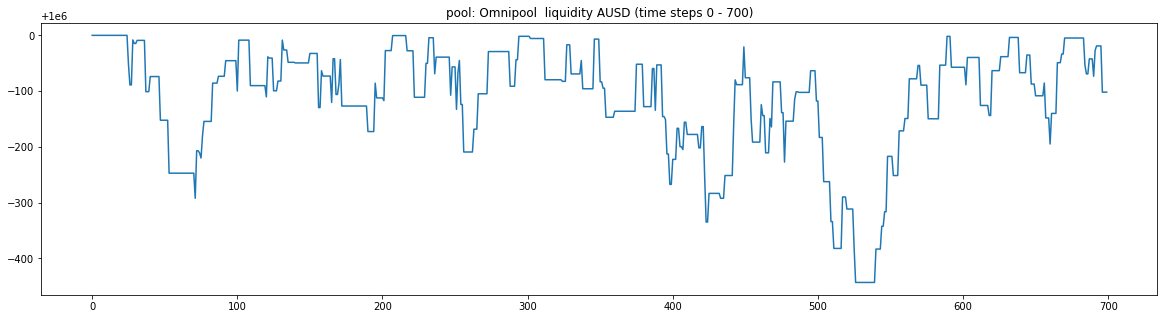

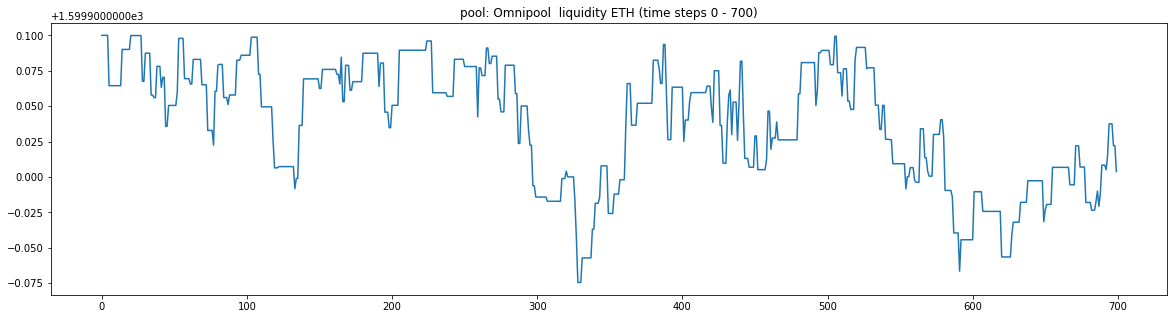

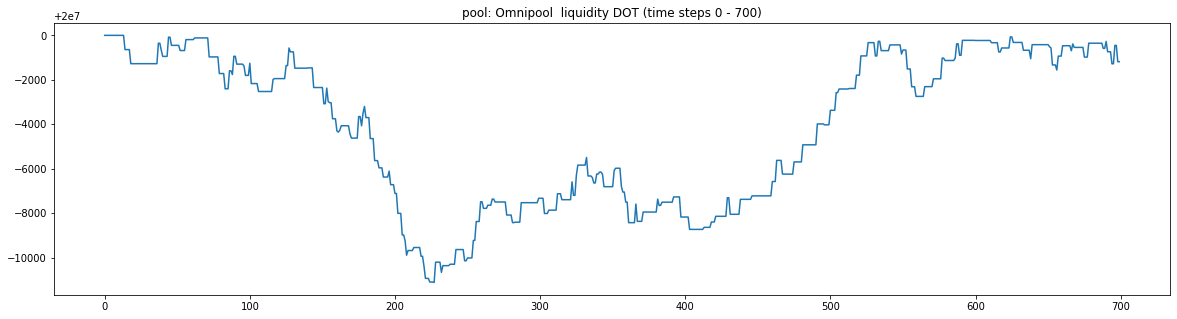

In [7]:
for tkn in assets:
    pu.plot(events2, pool='Omnipool', prop='liquidity', key=tkn, time_range=(0, 700))